# Task: Use the Poisson Blending Code to Seamlessly Insert an Image

In [1]:
#Import Packages

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import torch
import kornia
import scipy.sparse
import os

from kornia.filters import laplacian
from torchvision import datasets, transforms
from scipy.sparse.linalg import spsolve, cg

Packages include "torch" which contains data structures for multi-dimensional
tensors and mathematical operations over these are defined and "kornia" which consists of a set of routines and differentiable modules to solve generic computer vision problems.

Furthermore, we wish to utilize Polya's Problem-Solving Method for this problem.

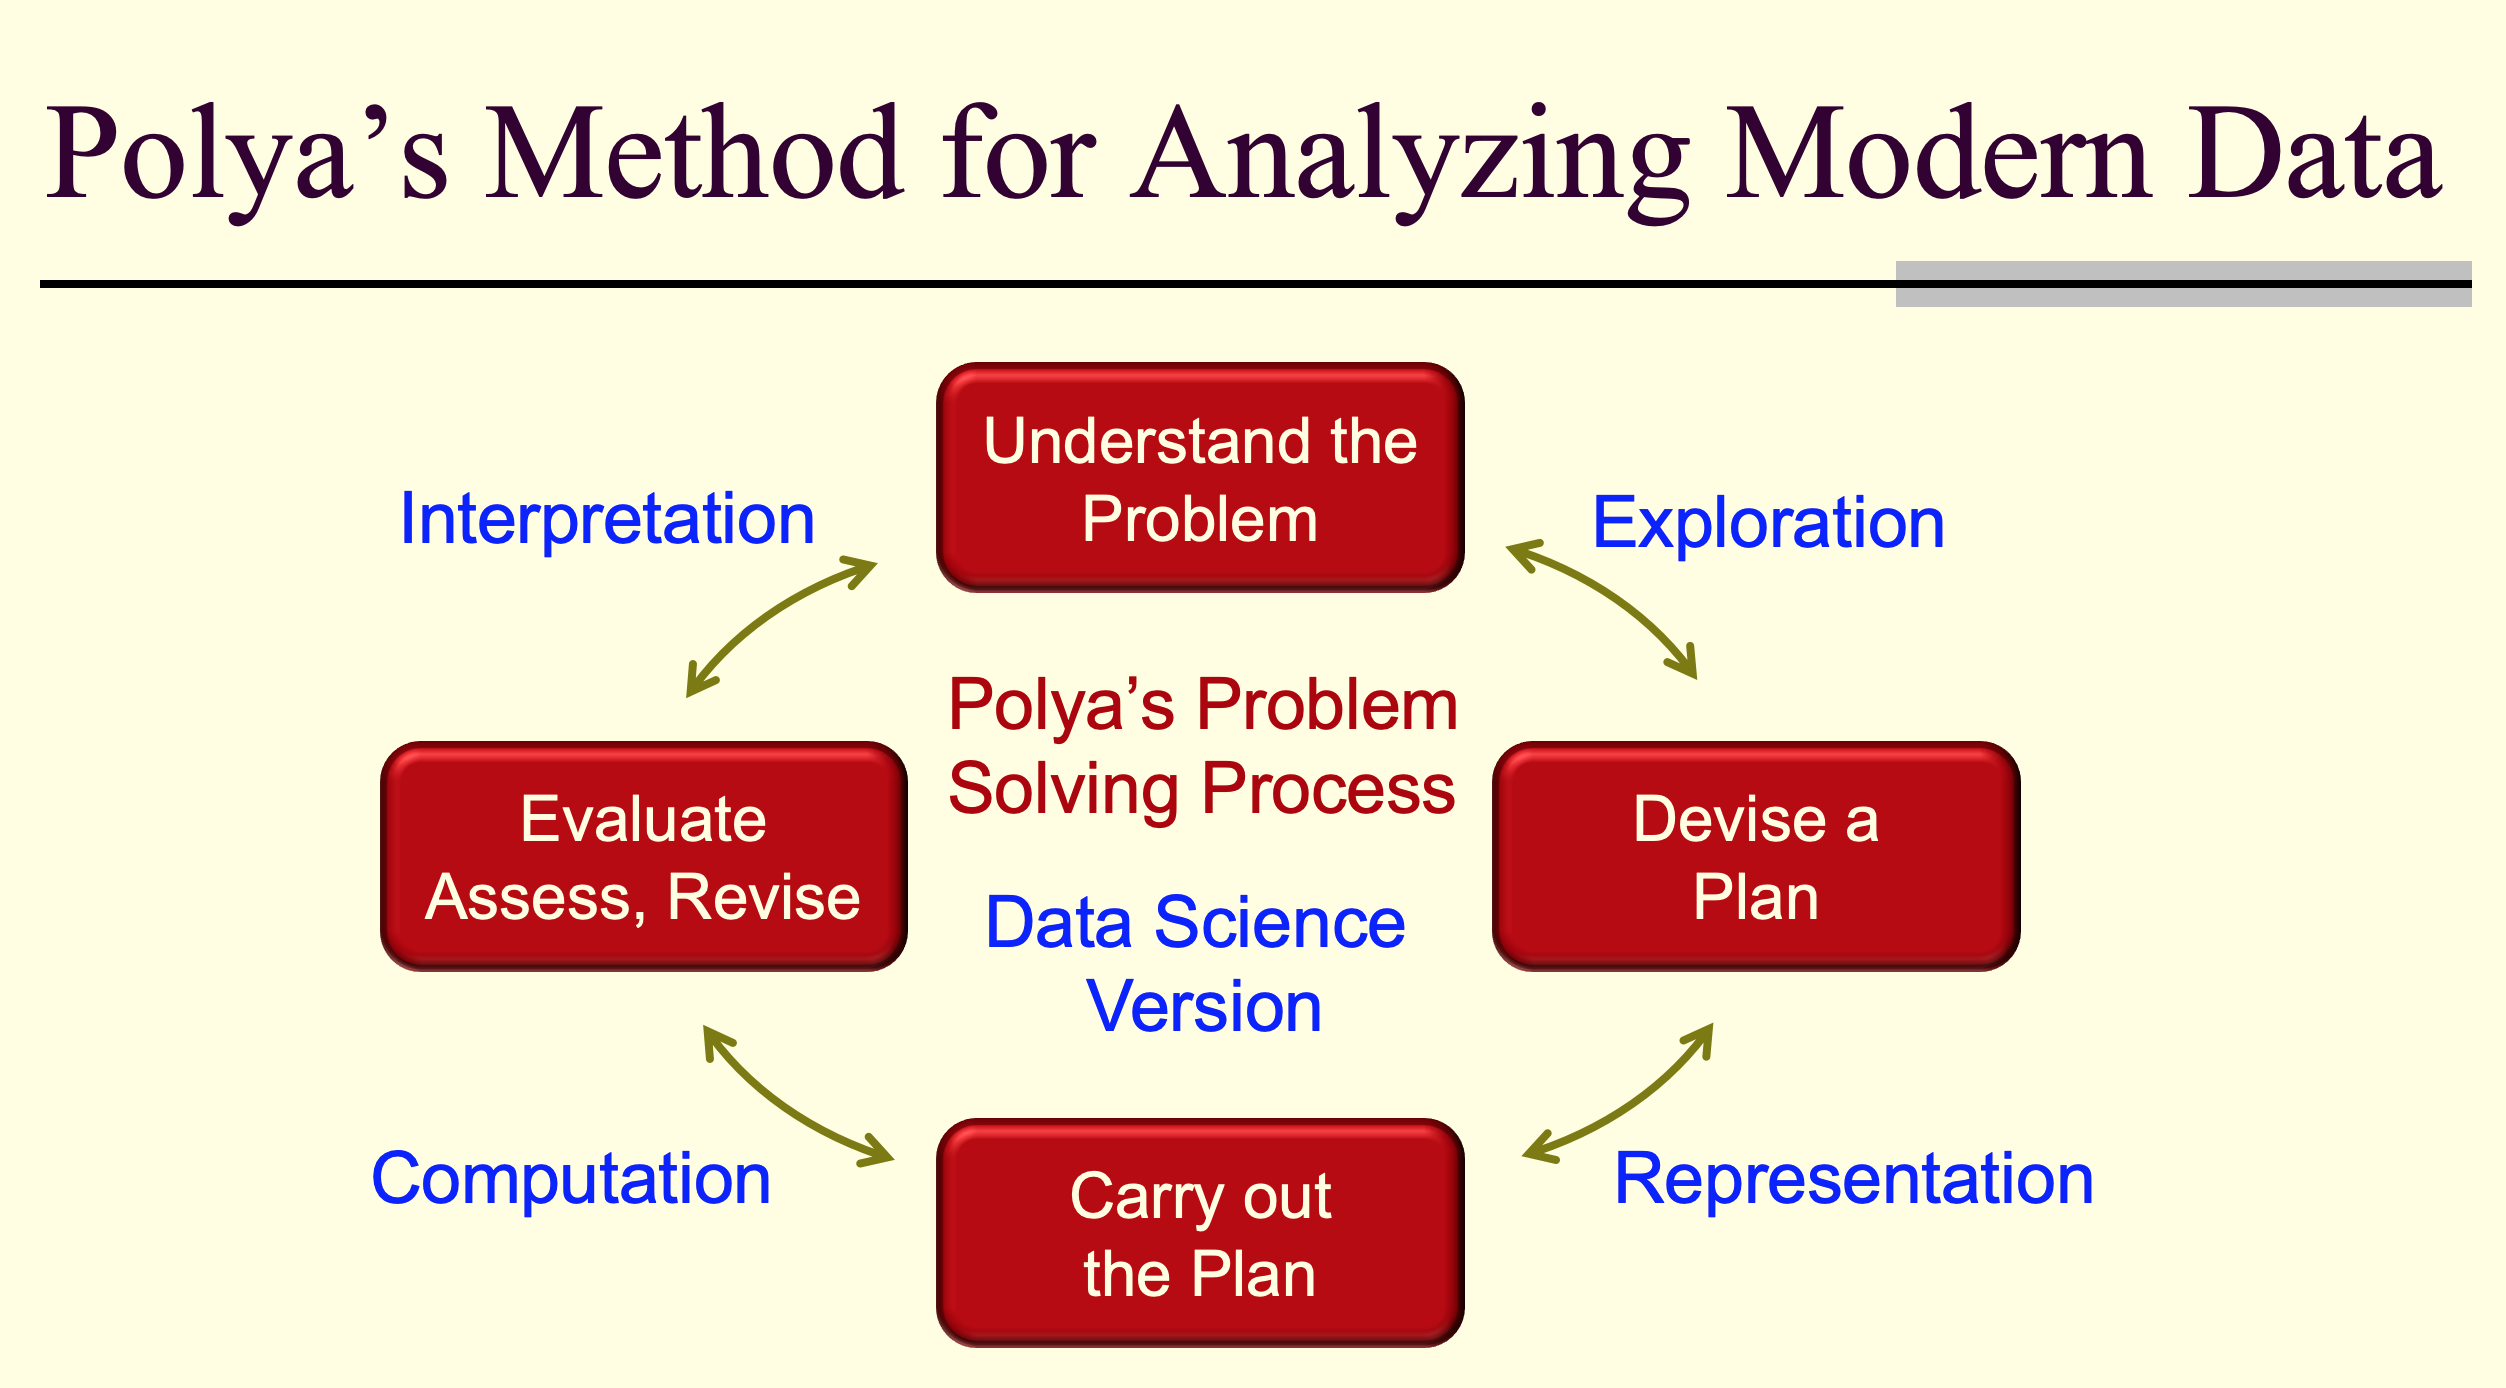

## Exploration
The objective of this project is to insert the image of the hot air balloon into the picture of the empty lot in such a way that the alteration cannot be detected. Problems like this are very common in the areas of computer vision and photo editing. For this example, images have shape (700,700,3) meaning they have a height and width of 700 pixels along with three separate layers of color values (RGB). 

## Representation
We start by importing two images and a simple black and white mask that outlines the part of the image to be transferred. Images are made up of pixels, each with a specific color value. Because of this inherent structure, matrices and tensors are often used to represent images in computing. Note that tensors can be defined as generalizations of matrices in $n$-dimensions. [cite]

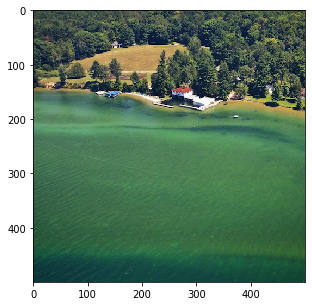

In [2]:
# specify kernel size
ker_size = 3

# empty lot in Johnson City
emptyLot = plt.imread('rex.png')
emptyLot = emptyLot / emptyLot.max()
plt.figure(figsize = (5,5))
plt.imshow(emptyLot)

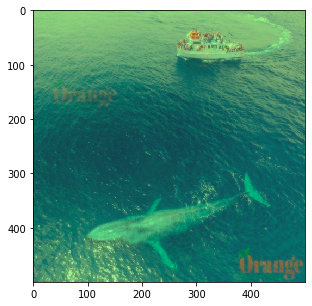

In [3]:
plane = plt.imread('whale.png')
plane = plane / plane.max()
plt.figure(figsize = (5,5))
plt.imshow(plane)

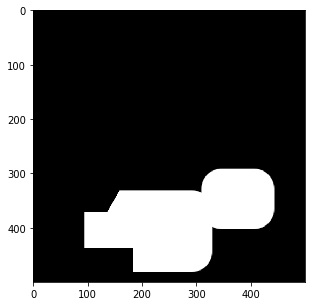

In [4]:
mask2 = plt.imread('whalemask.png')
mask2 = mask2 / mask2.max()
plt.figure(figsize = (5,5))
plt.imshow(mask2)

In [5]:
mask2.shape

(500, 500, 4)

When simply snipping one image and copying it onto another, the output does not look real.

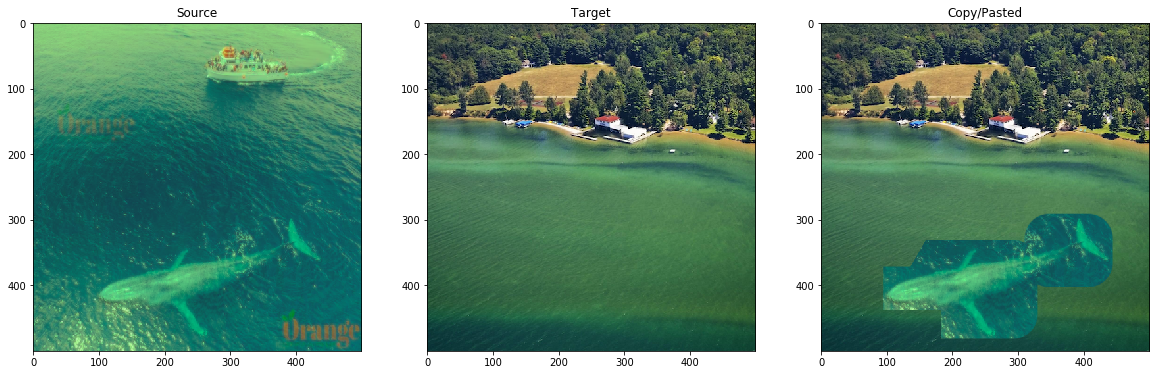

In [6]:
blendpic = (1-mask2)*emptyLot + (mask2)*plane
fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(plane)
ax[0].set_title('Source')
ax[1].imshow(emptyLot)
ax[1].set_title('Target');
ax[2].imshow(blendpic)
ax[2].set_title('Copy/Pasted');

A halo of mismatched color remains around the balloon. Hence, we must use a method that blends colors at the edges. To accomplish this, we utilize the Laplacian and the Network Laplacian.

## Computation
Images are converted to tensors, and the package "kornia" is used to return a tensor using a Laplacian filter. The operator smooths the given tensor with a laplacian kernel by convolving it to each channel. [cite]

In [7]:
# create a transform to transform the images to tensors
to_tensor = transforms.ToTensor()

In [8]:
# 'Unsqueeze' the image tensor to fit to the kornia filter's dimension requirements BxCxHxW
source2 = torch.unsqueeze(to_tensor(plane), dim=0)

# 'Unsqueeze' the image tensor to fit to the kornia filter's dimension requirements BxCxHxW
target2 = torch.unsqueeze(to_tensor(emptyLot), dim=0)

# Check shape of tensor
source2.shape, target2.shape

(torch.Size([1, 4, 500, 500]), torch.Size([1, 4, 500, 500]))

Given a pixel $(x,y)$ with intensity values $I_i$, the laplacian is, $L(x,y)$ is defined as
$$L(x,y)=\frac{\partial^2 I}{\partial x^2} + \frac{\partial^2 I}{\partial y^2} $$ Because pixels in an image are discrete, we need to approximate it using the convolution operator. [cite]. After we take the Laplacian of the tensor with the given kernel size, "kornia" is used again to transform the laplacian (or gradient) back into an image.

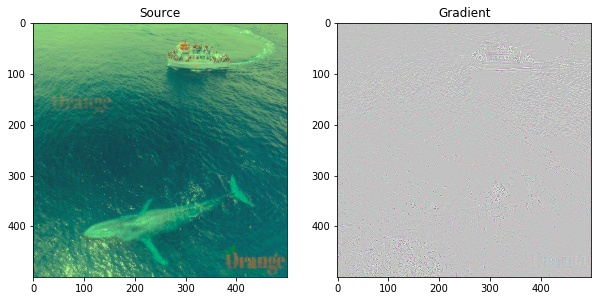

In [9]:
# take the laplacian of the tensor using a 3x3 kernel size
lapball = laplacian(source2, ker_size)
# convert the tensor back to image
imagelapball = kornia.tensor_to_image(lapball)
# take the laplacian of the tensor using a 3x3 kernel size
laplot = laplacian(target2, ker_size)
# convert the tensor back to image
imagelaplot = kornia.tensor_to_image(laplot)


# example output
fig,ax = plt.subplots(1,2,figsize = (10,20))
ax[0].imshow(plane)
ax[0].set_title('Source')
ax[1].imshow((imagelapball - imagelapball.min())/(imagelapball.max() - imagelapball.min()))
ax[1].set_title('Gradient');

Finally, the laplacian of the two images are combined based on the shape of the mask. This represents the "shape" of our final image, but we still must solve for the color difference.

In [10]:
# mixes the balloon of the source with everything but the balloon area of the target
blend_lap380 = (1-mask2)*imagelaplot + mask2*imagelapball

We define a function to create a Laplacian Matrix of a given size with "scipy."

In [11]:
import scipy.sparse

def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m), dtype = int)
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(8)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n, dtype = int).tolil()
    
    mat_A.setdiag(-1,  1*m)
    mat_A.setdiag(-1, -1*m)
    mat_A.setdiag(-1,  1*m+1)
    mat_A.setdiag(-1, -1*m+1)
    mat_A.setdiag(-1,  1*m-1)
    mat_A.setdiag(-1, -1*m-1)
    
    return mat_A

#sample output
#laplacian_matrix(4, 4).todense()

The output of the function defined in the previous cell is called the Laplacian Matrix $$L = D - A$$ where $D$ is the degree matrix, a diagonal matrix of vertex degrees, and $A$ is the adjacency matrix. The adjacency matrix is composed of 1's and 0's, a 1 indicating whether the vertices in the graph (in this case, image) are adjacent or connected. An adjacency matrix must also have a diagonal of 0's. [cite]

An input of $(m,n)$ results in a matrix of size $((m*n),(m*n))$.

Matrix $b$ is flattened, meaning it is transformed from size $(m,n)$ to size $((m*n),1)$. Columns are stacked on top of each other, and the sparse linear system can be solved with the new dimensions.

The Poisson equation is $$\Delta f = \mbox{div}\:\bf{v} $$ where $\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$ is the Laplacian and $\mbox{div}\:{\bf v} = \mbox{div}\:\nabla g = \mbox{div}\:(u,v) = \frac{\partial u}{\partial x}+ \frac{\partial v}{\partial y}$ is the divergence of the gradient. Hence,
$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}   =\frac{\partial u}{\partial x}+ \frac{\partial v}{\partial y}$$ and this leads us to the linear system.

Let the Laplacian Matrix be $L$ and the blended Laplacian be $b$. We use "spsolve" to get a solution to the sparse linear system $$Lx=b$$ where $b$ may be a vector or a matrix. There exist many other functions within "scipy.sparse.linalg" that can be used to solve the system such as conjugant gradients.

In [12]:
from scipy.sparse.linalg import spsolve, cg

mat_A380 = laplacian_matrix( *blend_lap380.shape[:-1] ).tocsc()
# tocsc() converts matrix to Compressed Sparse Column format

# solve for each level of the three color values (RGB)
ImgChans380 = []
for i in range(3):
    mat_b380 = blend_lap380[:,:,i].flatten()
    ImgChans380.append( spsolve(mat_A380, mat_b380) )
    print(i)

0
1
2


The idea behind this function is to solve the color equation for each of the three layers of the image, treating each layer as a unique matrix. Once all three levels are solved, we can recombine them using "numpy."

In [13]:
# blends three images into one
Blended380 = np.stack( [ img.reshape(blend_lap380.shape[:-1]) for img in ImgChans380], axis = 2)
Blended380

array([[[-1.77718657e-05,  4.00876415e-04,  3.40461997e-04],
        [ 2.26886748e-04,  6.89456295e-04,  8.51665521e-04],
        [ 2.92824484e-03,  3.14871867e-03,  3.23327100e-03],
        ...,
        [ 6.84709526e-03,  6.82198725e-03,  6.11174720e-03],
        [ 6.86149923e-03,  6.87086116e-03,  5.85043620e-03],
        [ 9.87264429e-03,  9.90887388e-03,  8.99937356e-03]],

       [[ 7.71035309e-04,  7.03187080e-04,  7.95561964e-04],
        [ 2.61778105e-04,  2.38823183e-04,  4.10431491e-04],
        [ 5.67884930e-04,  5.33848964e-04,  3.17913410e-04],
        ...,
        [-2.03980183e-03, -1.76435390e-03, -2.52712722e-03],
        [-1.18231082e-03, -1.14733673e-03, -1.44393131e-03],
        [ 1.68847952e-03,  1.44183878e-03,  1.59479827e-03]],

       [[ 4.47439951e-03,  4.05769659e-03,  4.37870229e-03],
        [ 2.23059153e-03,  1.98308342e-03,  2.21980756e-03],
        [ 2.26677844e-04, -4.74552802e-05, -3.03973421e-05],
        ...,
        [ 1.13883974e-03,  1.22094313e-03,

Here we see the result: an image transferred from the source to the target in a way that the shape (gradient) of the balloon is maintained, but the colors have been adjusted to its new surroundings. 

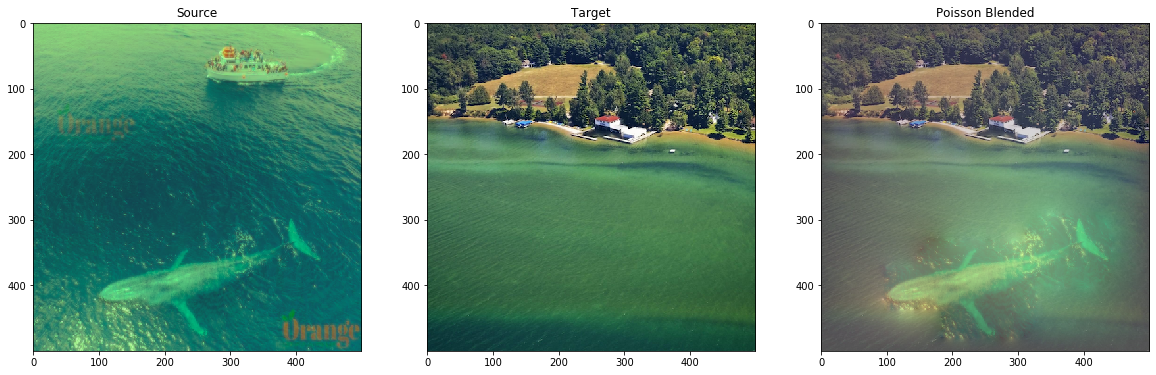

In [14]:
Blended380 = 1 - (Blended380 - Blended380.min())/(Blended380.max() - Blended380.min())

fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(plane)
ax[0].set_title('Source')
ax[1].imshow(emptyLot)
ax[1].set_title('Target');
ax[2].imshow(Blended380)
ax[2].set_title('Poisson Blended');

## Interpretation
While not perfect, the image created with Poisson editing looks much more authentic than our original attempt. The code for this project gives anyone a powerful and relatively simple method to create convincing "deep-fakes." Still, issues arise when color or texture differences between the source and target images are very large. Furthermore, it is time-consuming to create the black-and-white mask, so a method for extracting the image using the gradient would be of use.

## References